<a href="https://colab.research.google.com/github/ilushaKolosov/AI_ChessGame/blob/master/AI_ChessGame_FinalWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install chess
import chess
import pandas as pd
import numpy as np
from google.colab import files
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
import matplotlib.pyplot as plt

# https://www.kaggle.com/datasets/datasnaek/chess?select=games.csv

In [10]:
import kagglehub
import shutil
import os

# Скачать последнюю версию датасета
path = kagglehub.dataset_download("datasnaek/chess")

# Определить целевую папку
destination = "/content/sample_data"

# Переместить все файлы из загруженной папки в sample_data
for file_name in os.listdir(path):
    src_path = os.path.join(path, file_name)
    dest_path = os.path.join(destination, file_name)

    if os.path.exists(dest_path):
        os.remove(dest_path)  # Удаляем, если файл уже существует

    shutil.move(src_path, destination)

# Удалить пустую папку после перемещения файлов
os.rmdir(path)

print("Датасет перемещен в:", destination)


Датасет перемещен в: /content/sample_data


In [11]:
name = 'sample_data/1/games.csv'
colums = ['id','rated','created_at','last_move_at','turns','victory_status','winner','increment_code','white_id','white_rating','black_id','black_rating','moves','opening_eco','opening_name','opening_ply']
df = pd.read_csv(name, names = colums )

In [12]:
# создаем массивы данных

print('Started...')

combination_code = ''

histories = []                  # массив историй
status = []                     # массив статусов партий
x = []                          # массив комбинаций в собственной кодировке доски
y = []                          # массив результатов партии (победа/поражение) с комбинациями x
fen_massive = []                # массив в кодировке fen
fen_and_code_combination = []   # массив совместный в кодировке fen и в собственной кодировке доски

PIECE_SYMBOLS_NEW = ['.','P','R', 'N','B','Q','K','p','n','b', 'r','q','k']
def piece(cell): return str(board.piece_at(cell)) if str(board.piece_at(cell)) != 'None' else '.'

# готовим набор историй
histories = [ key for key in df.moves]
histories.pop(0)

# готовим набор классов
status = [ 1 if key == 'white' else 0 for key in df.winner]
status.pop(0)

# запускаем цикл прохода по историям
for histories_index, this_history in enumerate(histories):
  if histories_index % 1000 == 0: print(histories_index)

  # запускаем партию заново
  board=chess.Board()
  fen = board.fen()
  combination_code = [PIECE_SYMBOLS_NEW.index(piece(cell)) for cell in range(64)]

  # для теста и демонстрации берем первые 10, чтобы сократить время
  for index, key in enumerate(histories[histories_index].split()[:10]):

    # как бы делаем ход
    board.push_san(key)

    # фиксируем только ситуацию для белых, поэтому смотрим четную запись
    if index % 2 == 0:
      fen = board.fen()
      combination_code = [PIECE_SYMBOLS_NEW.index(piece(cell)) for cell in range(64)]

      # добавляем значения в массивы
      x.append(combination_code)
      y.append(status[histories_index])
      fen_massive.append(fen)
      fen_and_code_combination.append([fen, combination_code])

print('Finished')

Started...
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
Finished


In [13]:
# создаем массив уникальных комбинаций fen
fen_massive_unicum = list(set(fen_massive))

# создаем массив уникальных комбинаций fen с подсчетом количества побед
# столбцы: fen, общее количество, количество побед, количество поражений, процент победных

print('Started...')

fen_massive_unicum_counter = []

# формируем список с fen нужным количеством столбцов
for key in fen_massive_unicum:
  fen_massive_unicum_counter.append([key, 0,0,0,0])

# теперь загоняем в него показатели
for index, key in enumerate(fen_massive_unicum_counter):
  if index % 1000 == 0: print(index)
  for index2, key2 in enumerate(fen_massive):
    if key[0] == key2:
      key[1] += 1
      if y[index2] == 1: key[2] += 1
      else: key[3] += 1
      key[4] = key[2]/key[1]

print()
print('Finished')

Started...
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000

Finished


In [14]:
# смотрим доступные ходы первого хода белых

# в начало партии
board=chess.Board()
fen = board.fen()

win_percent = []
legals = []

# первый  слой доступных ходов
for key in board.legal_moves:
  legals.append(str(key))

# перебираем доступные ходы
for index, legal_move in enumerate(legals):
  board.push_san(legal_move)
  fen = board.fen()

  #ищем комбинации
  for key in fen_massive_unicum_counter:
    if fen == key[0]:
      print(index,'move:',legal_move, 'total:', key[1], 'wins:', key[2], 'percent:', key[4])
      win_percent.append([legal_move, key[1], key[4]])

      break
  board.pop()

print()
print('len(win_percent):', len(win_percent))

0 move: g1h3 total: 15 wins: 9 percent: 0.6
1 move: g1f3 total: 725 wins: 373 percent: 0.5144827586206897
2 move: b1c3 total: 99 wins: 42 percent: 0.42424242424242425
3 move: b1a3 total: 4 wins: 1 percent: 0.25
4 move: h2h3 total: 14 wins: 7 percent: 0.5
5 move: g2g3 total: 186 wins: 85 percent: 0.45698924731182794
6 move: f2f3 total: 23 wins: 8 percent: 0.34782608695652173
7 move: e2e3 total: 416 wins: 142 percent: 0.34134615384615385
8 move: d2d3 total: 131 wins: 50 percent: 0.3816793893129771
9 move: c2c3 total: 56 wins: 31 percent: 0.5535714285714286
10 move: b2b3 total: 173 wins: 82 percent: 0.47398843930635837
11 move: a2a3 total: 27 wins: 17 percent: 0.6296296296296297
12 move: h2h4 total: 33 wins: 6 percent: 0.18181818181818182
13 move: g2g4 total: 38 wins: 11 percent: 0.2894736842105263
14 move: f2f4 total: 166 wins: 68 percent: 0.40963855421686746
15 move: e2e4 total: 12598 wins: 6371 percent: 0.50571519288776
16 move: d2d4 total: 4522 wins: 2258 percent: 0.49933657673595755


In [15]:
# создаем массив из вторых ходов белых

fen_massive_unicum_counter_2 = []
for key in fen_massive_unicum_counter:
  if key[0][-1] == '2' and key[0][-2] == ' ':
    fen_massive_unicum_counter_2.append(key)

In [16]:
fen_massive_unicum_counter_all = []
for key in fen_massive_unicum_counter:
  if key[0][-2] == ' ':
    fen_massive_unicum_counter_all.append(key)

In [17]:
# создаем массив уникальных fen из вторых ходов белых

fen_massive_unicum_2 = []
for key in fen_massive_unicum_counter_2:
    fen_massive_unicum_2.append(key[0])

# приводим в соответствие уникальные fen второго хода белых и собственную кодировку

fen_and_combination_code_unicum_2 = []
for key in fen_massive_unicum_2:
  for key2 in fen_and_code_combination:
    if key == key2[0]:
      fen_and_combination_code_unicum_2.append([key, key2[1]])
      break

In [18]:

fen_massive_unicum_all = []
for key in fen_massive_unicum_counter_all:
    fen_massive_unicum_all.append(key[0])

fen_and_combination_code_unicum_all = []
for key in fen_massive_unicum_all:
  for key2 in fen_and_code_combination:
    if key == key2[0]:
      fen_and_combination_code_unicum_all.append([key, key2[1]])
      break

In [19]:
# создаем массив комбинаций в собственной кодировке для последующей передачи в модель
# x_train_2 = [ key[1] for key in fen_and_combination_code_unicum_2 ]
x_train_2 = [ key[1] for key in fen_and_combination_code_unicum_all ]

# создаем массив меток для последующей передачи в модель
# y_train_2 = [ ( 1 if key[4] > 0.5 else 0 )for key in fen_massive_unicum_counter_2 ]
y_train_2 = [ ( 1 if key[4] > 0.5 else 0 )for key in fen_massive_unicum_counter_all ]

# переводим x_train_2 в цифры и массив numpy
x_train = np.array([ [ int(key2) for key2 in key  ] for key in x_train_2  ])

# переводим y_train_2 в цифры и массив numpy
y_train = np.array([int(key) for key in y_train_2])

🔹 Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
m

<ipython-input-33-5f9e7e595754>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['winner'], palette="coolwarm")


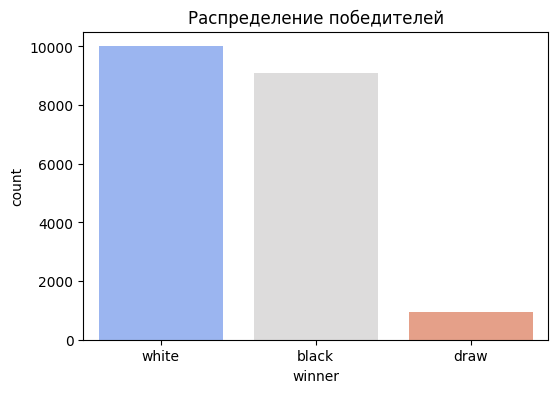

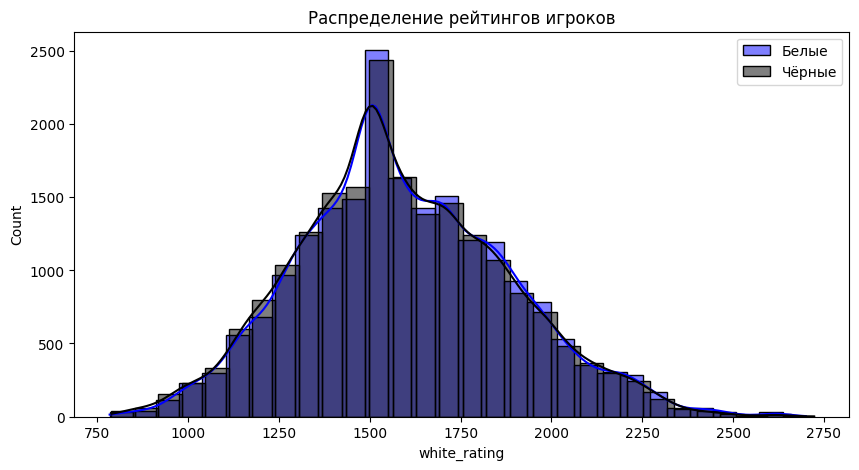

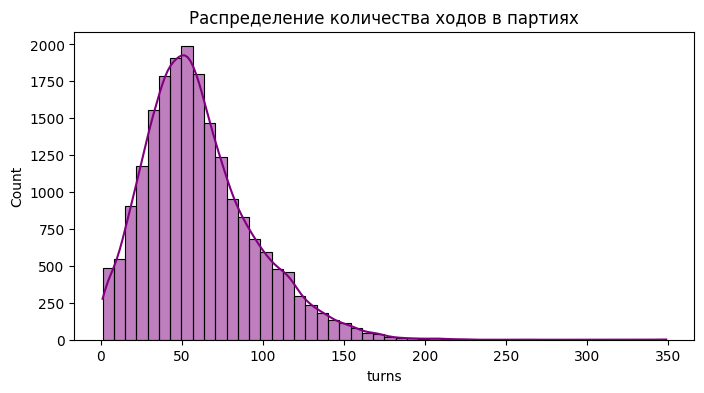

<ipython-input-33-5f9e7e595754>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_openings.values, y=top_openings.index, palette="viridis")


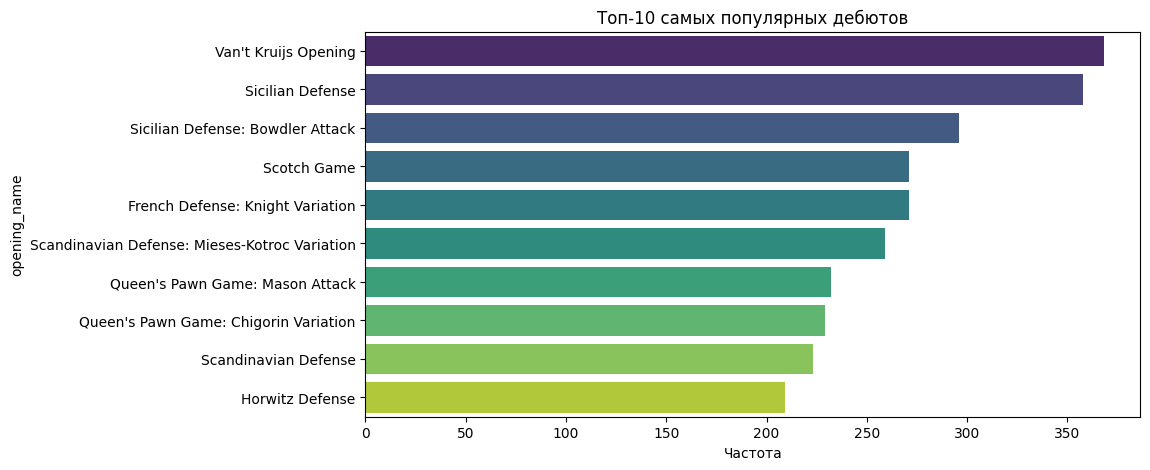

<ipython-input-33-5f9e7e595754>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['victory_status'], palette="magma")


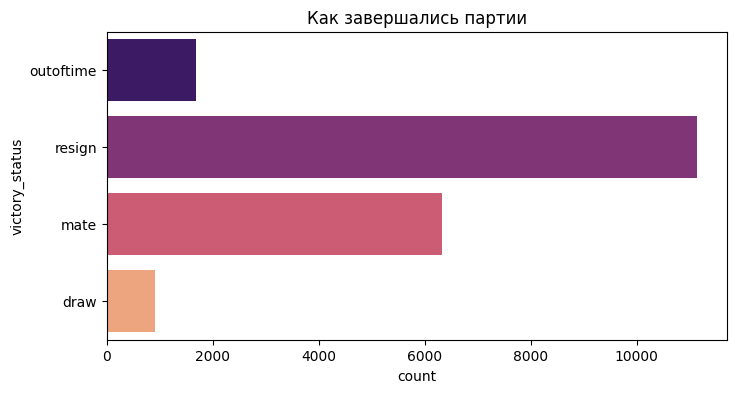

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка датасета (замени 'your_dataset.csv' на свой файл)
df = pd.read_csv('sample_data/1/games.csv')

# Общая информация
print("🔹 Общая информация о датасете:")
print(df.info())

# Проверка на пропущенные значения
print("\n🔹 Пропущенные значения:")
print(df.isnull().sum())

# Основные статистики по числовым данным
print("\n🔹 Описательная статистика:")
print(df.describe())

# Победитель (белые или чёрные)
plt.figure(figsize=(6, 4))
sns.countplot(x=df['winner'], palette="coolwarm")
plt.title("Распределение победителей")
plt.show()

# Распределение рейтингов
plt.figure(figsize=(10, 5))
sns.histplot(df['white_rating'], bins=30, kde=True, color='blue', label='Белые')
sns.histplot(df['black_rating'], bins=30, kde=True, color='black', label='Чёрные')
plt.legend()
plt.title("Распределение рейтингов игроков")
plt.show()

# Количество ходов в партиях
plt.figure(figsize=(8, 4))
sns.histplot(df['turns'], bins=50, kde=True, color='purple')
plt.title("Распределение количества ходов в партиях")
plt.show()

# Популярные дебюты
top_openings = df['opening_name'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_openings.values, y=top_openings.index, palette="viridis")
plt.title("Топ-10 самых популярных дебютов")
plt.xlabel("Частота")
plt.show()

# Способы завершения партии
plt.figure(figsize=(8, 4))
sns.countplot(y=df['victory_status'], palette="magma")
plt.title("Как завершались партии")
plt.show()


In [20]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

# Путь для сохранения модели
model_path = "model_1.keras"

if os.path.exists(model_path):
    print("Загружаем сохранённую модель...")
    model_1 = keras.models.load_model(model_path)
else:
    print("Обучаем новую модель...")
    model_1 = keras.Sequential([
        Dense(128, activation='relu', input_shape=(64,)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    myAdam = keras.optimizers.Adam(learning_rate=0.0001)
    model_1.compile(optimizer=myAdam, loss='binary_crossentropy', metrics=['accuracy'])

    Epochs = 100
    history_1 = model_1.fit(x_train, y_train, batch_size=32, epochs=Epochs, validation_split=0.2)

    # Сохранение модели
    model_1.save(model_path)
    print("Модель сохранена.")

# Проверка точности модели
loss, acc = model_1.evaluate(x_train, y_train)
print(f"Loss: {loss}, Accuracy: {acc}")


Обучаем новую модель...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5297 - loss: 0.6993 - val_accuracy: 0.5628 - val_loss: 0.6814
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5567 - loss: 0.6822 - val_accuracy: 0.5632 - val_loss: 0.6806
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5774 - loss: 0.6755 - val_accuracy: 0.5670 - val_loss: 0.6775
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5891 - loss: 0.6703 - val_accuracy: 0.5703 - val_loss: 0.6762
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5925 - loss: 0.6689 - val_accuracy: 0.5790 - val_loss: 0.6752
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6038 - loss: 0.6608 - val_accuracy: 0.5721 - val_loss: 0.6762
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6073 - loss: 0.6587 - val_accuracy: 0.5635 - val_loss: 0.6811
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6187 - loss: 0.6533 - val_accu

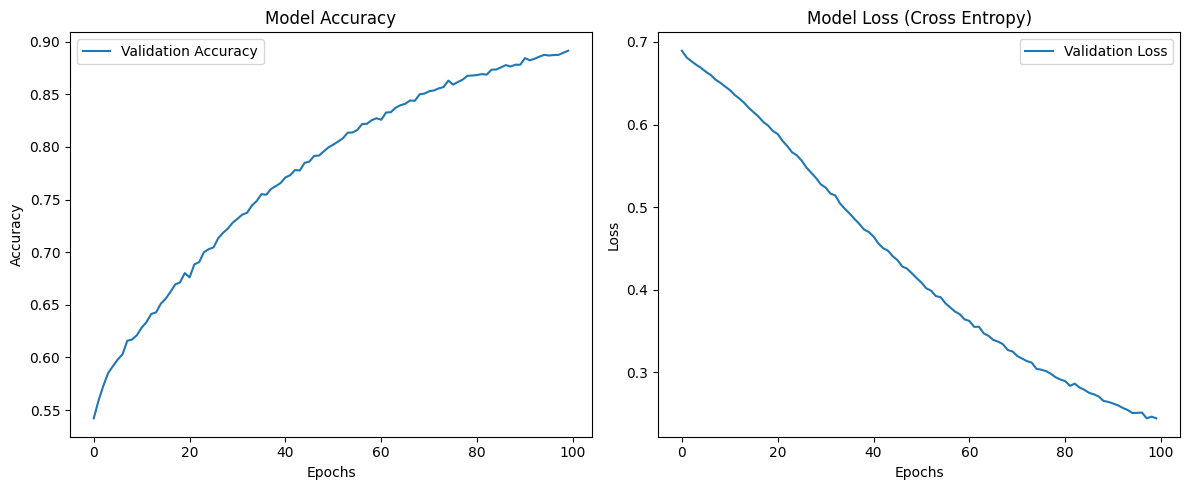

In [21]:
import matplotlib.pyplot as plt

# Построение графика точности
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Построение графика функции потерь
plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss (Cross Entropy)')
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
# самое начало
board=chess.Board()
fen = board.fen()

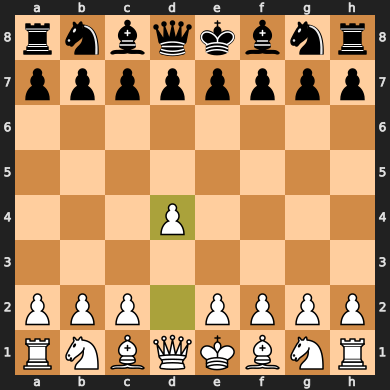

In [23]:
this_move = 'd2d4'
board.push_san(this_move)
board


['b8a6', 0.99999917]



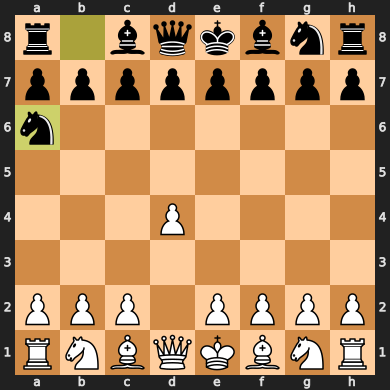

In [24]:
# играет модель

legals = []
recom = []

# первый  слой доступных ходов
for key in board.legal_moves:
  legals.append(str(key))

# перебираем доступные ходы
for index, legal_move in enumerate(legals):

  board.push_san(legal_move)
  fen = board.fen()
  combination_code = [PIECE_SYMBOLS_NEW.index(piece(cell)) for cell in range(64)]
  x_analised = np.array([ int(key) for key in combination_code ])
  x = np.expand_dims(x_analised, axis=0)

  # вот здесь пишем название применяемой модели
  res = model_1.predict(x, verbose=0)
  recom.append([legal_move, res[0][0]])

  board.pop()

print()

# печатаем ход и оценку
ind = np.argmax([ key[1] for key in recom ])
print(recom[ind])
print()

# делаем ход
board.push_san(recom[ind][0])

# выводим изображение доски
board

In [25]:
# смотрим все доступные ходы в порядке уьывания оценки
for key in reversed(np.argsort([ key[1] for key in recom  ] )):
  print(recom[key])

['b8a6', 0.99999917]
['g7g5', 0.99980634]
['g8h6', 0.99244136]
['b7b5', 0.98922133]
['f7f6', 0.9836992]
['h7h6', 0.9819729]
['a7a5', 0.9343134]
['a7a6', 0.91182566]
['d7d6', 0.8927055]
['c7c6', 0.8395513]
['h7h5', 0.6759312]
['b8c6', 0.6352582]
['g7g6', 0.5749993]
['e7e5', 0.5081769]
['d7d5', 0.45165914]
['b7b6', 0.40877366]
['e7e6', 0.3814506]
['c7c5', 0.32249373]
['f7f5', 0.15788025]
['g8f6', 0.07648806]



['d1d3', 1.0]



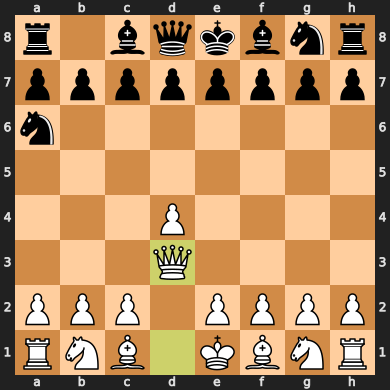

In [26]:
# играет модель

legals = []
recom = []

# первый  слой доступных ходов
for key in board.legal_moves:
  legals.append(str(key))

# перебираем доступные ходы
for index, legal_move in enumerate(legals):

  board.push_san(legal_move)
  fen = board.fen()
  combination_code = [PIECE_SYMBOLS_NEW.index(piece(cell)) for cell in range(64)]
  x_analised = np.array([ int(key) for key in combination_code ])
  x = np.expand_dims(x_analised, axis=0)

  # вот здесь пишем название применяемой модели
  res = model_1.predict(x, verbose=0)
  recom.append([legal_move, res[0][0]])

  board.pop()

print()

# печатаем ход и оценку
ind = np.argmax([ key[1] for key in recom ])
print(recom[ind])
print()

# делаем ход
board.push_san(recom[ind][0])

# выводим изображение доски
board


['g8f6', 1.0]



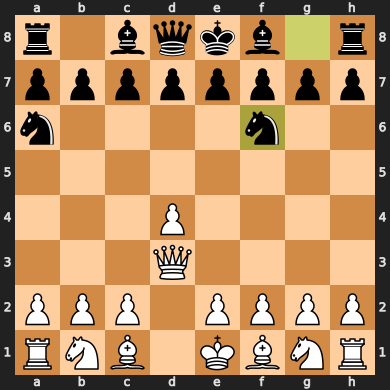

In [27]:
# играет модель

legals = []
recom = []

# первый  слой доступных ходов
for key in board.legal_moves:
  legals.append(str(key))

# перебираем доступные ходы
for index, legal_move in enumerate(legals):

  board.push_san(legal_move)
  fen = board.fen()
  combination_code = [PIECE_SYMBOLS_NEW.index(piece(cell)) for cell in range(64)]
  x_analised = np.array([ int(key) for key in combination_code ])
  x = np.expand_dims(x_analised, axis=0)

  # вот здесь пишем название применяемой модели
  res = model_1.predict(x, verbose=0)
  recom.append([legal_move, res[0][0]])

  board.pop()

print()

# печатаем ход и оценку
ind = np.argmax([ key[1] for key in recom ])
print(recom[ind])
print()

# делаем ход
board.push_san(recom[ind][0])

# выводим изображение доски
board


['d3b5', 1.0]



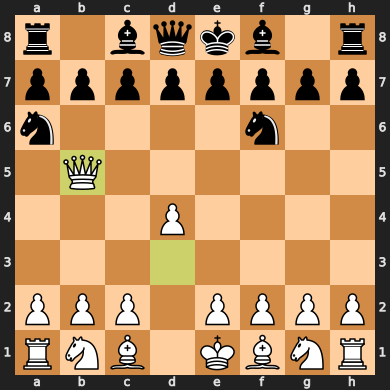

In [28]:
# играет модель

legals = []
recom = []

# первый  слой доступных ходов
for key in board.legal_moves:
  legals.append(str(key))

# перебираем доступные ходы
for index, legal_move in enumerate(legals):

  board.push_san(legal_move)
  fen = board.fen()
  combination_code = [PIECE_SYMBOLS_NEW.index(piece(cell)) for cell in range(64)]
  x_analised = np.array([ int(key) for key in combination_code ])
  x = np.expand_dims(x_analised, axis=0)

  # вот здесь пишем название применяемой модели
  res = model_1.predict(x, verbose=0)
  recom.append([legal_move, res[0][0]])

  board.pop()

print()

# печатаем ход и оценку
ind = np.argmax([ key[1] for key in recom ])
print(recom[ind])
print()

# делаем ход
board.push_san(recom[ind][0])

# выводим изображение доски
board


['f6g8', 1.0]



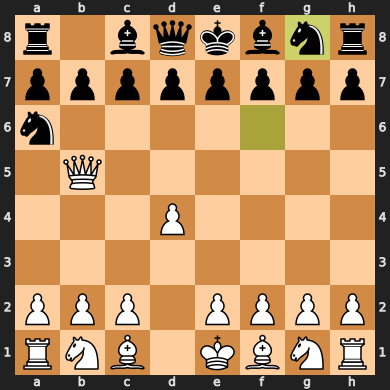

In [29]:
# играет модель

legals = []
recom = []

# первый  слой доступных ходов
for key in board.legal_moves:
  legals.append(str(key))

# перебираем доступные ходы
for index, legal_move in enumerate(legals):

  board.push_san(legal_move)
  fen = board.fen()
  combination_code = [PIECE_SYMBOLS_NEW.index(piece(cell)) for cell in range(64)]
  x_analised = np.array([ int(key) for key in combination_code ])
  x = np.expand_dims(x_analised, axis=0)

  # вот здесь пишем название применяемой модели
  res = model_1.predict(x, verbose=0)
  recom.append([legal_move, res[0][0]])

  board.pop()

print()

# печатаем ход и оценку
ind = np.argmax([ key[1] for key in recom ])
print(recom[ind])
print()

# делаем ход
board.push_san(recom[ind][0])

# выводим изображение доски
board


['b5d7', 1.0]



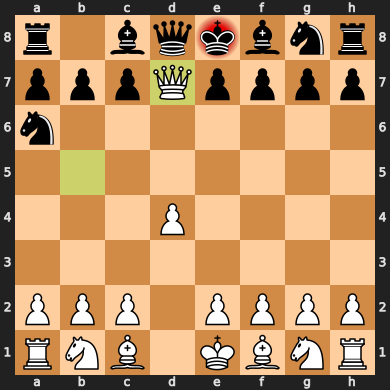

In [30]:
# играет модель

legals = []
recom = []

# первый  слой доступных ходов
for key in board.legal_moves:
  legals.append(str(key))

# перебираем доступные ходы
for index, legal_move in enumerate(legals):

  board.push_san(legal_move)
  fen = board.fen()
  combination_code = [PIECE_SYMBOLS_NEW.index(piece(cell)) for cell in range(64)]
  x_analised = np.array([ int(key) for key in combination_code ])
  x = np.expand_dims(x_analised, axis=0)

  # вот здесь пишем название применяемой модели
  res = model_1.predict(x, verbose=0)
  recom.append([legal_move, res[0][0]])

  board.pop()

print()

# печатаем ход и оценку
ind = np.argmax([ key[1] for key in recom ])
print(recom[ind])
print()

# делаем ход
board.push_san(recom[ind][0])

# выводим изображение доски
board


['d8d7', 1.0]



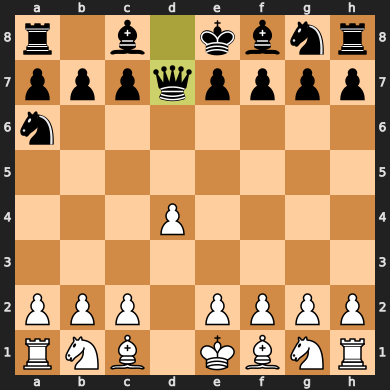

In [31]:
# играет модель

legals = []
recom = []

# первый  слой доступных ходов
for key in board.legal_moves:
  legals.append(str(key))

# перебираем доступные ходы
for index, legal_move in enumerate(legals):

  board.push_san(legal_move)
  fen = board.fen()
  combination_code = [PIECE_SYMBOLS_NEW.index(piece(cell)) for cell in range(64)]
  x_analised = np.array([ int(key) for key in combination_code ])
  x = np.expand_dims(x_analised, axis=0)

  # вот здесь пишем название применяемой модели
  res = model_1.predict(x, verbose=0)
  recom.append([legal_move, res[0][0]])

  board.pop()

print()

# печатаем ход и оценку
ind = np.argmax([ key[1] for key in recom ])
print(recom[ind])
print()

# делаем ход
board.push_san(recom[ind][0])

# выводим изображение доски
board